# Blog post classification using Natural Language Processing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
meta_train_df = pd.read_json (r'/content/drive/Shareddrives/Text Analytics/Project/train.json')
meta_test_df = pd.read_json (r'/content/drive/Shareddrives/Text Analytics/Project/test.json')

In [ ]:
import os 
os.chdir('/content/drive/Shareddrives/Text Analytics/Project/')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk import wordnet as wn
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


###Data Preparation --- 

In [ ]:
# trying varying with number of training samples - 1000, 10000,20000 

n = 10000   ### number of trainig documents
m = 5000   ## test is fixed as 5000 documents
train_df = meta_train_df.loc[0:n,]
test_df = meta_test_df.loc[0:m,]

train_df.shape, test_df.shape

((10001, 3), (5001, 3))

In [ ]:
train_df.head()

,post,age,gender
0,ooh shiny new commenting!,16,female
1,so wuts up? today i had the parade. suked. but...,14,male
2,"i don't know about anyone else anymore, but i'...",24,female
3,urlLink another roof-top sunset Posted by ...,24,male
4,gawd i luv my nanny! she's absolutely the gre...,23,female


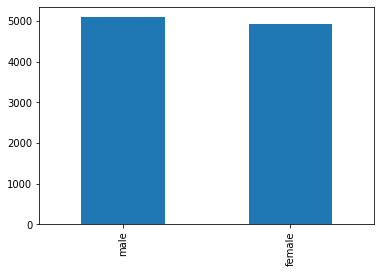

In [ ]:
# grouping age groups into three classes
"""
00 - 17 -> Minor
23 - 27 -> Adult
33 - up -> Mature

"""

def age_grouping(age):
  if age >=33:
    return 'Mature'
  elif age <= 17:
    return 'Minor'
  else:
    return 'Adult'


train_df['age_group'] = train_df['age'].apply(lambda x: age_grouping(x))
test_df['age_group'] = test_df['age'].apply(lambda x: age_grouping(x))

# gender 0 for male, 1 for female 

train_df['gender'].value_counts().plot(kind = 'bar')

train_df['gender'] = train_df['gender'].apply(lambda x: 0 if x == 'male' else 1)
test_df['gender'] = test_df['gender'].apply(lambda x: 0 if x == 'male' else 1)

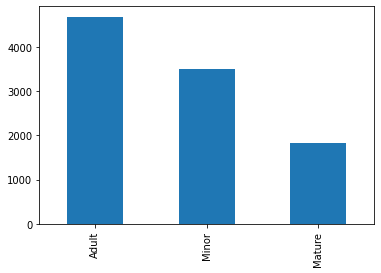

In [ ]:
train_df['age_group'].value_counts().plot(kind = 'bar')

In [ ]:
from collections import Counter


def get_words(category):
  temp_df = train_df[train_df['age_group']==category]
  text = temp_df.post.str.cat()
  # split_it = data_set.split()

  # Pass the split_it list to instance of Counter class.
  counter_dict = Counter(text.lower().split())
  #print(Counter)

  # most_common() produces k frequently encountered
  # input values and their respective counts.
  most_occur = counter_dict.most_common(10)
  print(category + ' top 10 word and counts are ')
  print(most_occur)

  return most_occur


for group in ['Minor','Adult','Mature']:
  _ = get_words(group)

Minor top 10 word and counts are 
[('i', 24266), ('the', 20587), ('to', 17624), ('and', 16589), ('a', 11779), ('of', 9193), ('my', 7426), ('that', 7049), ('in', 6683), ('it', 6637)]
Adult top 10 word and counts are 
[('the', 38210), ('i', 30488), ('to', 27771), ('and', 24456), ('a', 21085), ('of', 17997), ('in', 12249), ('that', 11991), ('my', 10215), ('is', 9936)]
Mature top 10 word and counts are 
[('the', 18698), ('to', 12098), ('i', 11305), ('and', 11102), ('a', 9527), ('of', 8865), ('in', 6112), ('that', 5258), ('is', 4189), ('my', 4090)]


In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_df['age_group'])
test_y = encoder.fit_transform(test_df['age_group'])

### Feature Engineering 

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.

- Count Vectors as features
- TF-IDF Vectors as features

      Word level
      N-Gram level

- Word Embeddings as features


## Count Vectors

In [ ]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_df['post'])

# transform the training and validation data using count vectorizer object
train_count =  count_vect.transform(train_df['post'])
test_count =  count_vect.transform(test_df['post'])

## tf_idf 
      word
      ngram
\

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train_df['post'])
train_tfidf =  tfidf_vect.transform(train_df['post'])
test_tfidf =  tfidf_vect.transform(test_df['post'])

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train_df['post'])
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_df['post'])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_df['post'])

# Baseline model - NB Bernoulli

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, test_y), metrics.f1_score(predictions,test_y,average='weighted')

In [ ]:
# Naive Bayes on Count Vectors
accuracy,f1_score = train_model(naive_bayes.BernoulliNB(), train_count, train_y, test_count)
print("NB, Accuracy of Count Vectors: ", accuracy)
print("NB, F1 score of Count Vectors: ", f1_score)

# Naive Bayes on Word Level TF IDF Vectors
accuracy,f1_score = train_model(naive_bayes.BernoulliNB(), train_tfidf, train_y, test_tfidf)
print("NB, Accuracy of WordLevel TF-IDF: ", accuracy)
print("NB, F1 score of TF-IDF: ", f1_score)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy,f1_score = train_model(naive_bayes.BernoulliNB(), train_tfidf_ngram, train_y, test_tfidf_ngram)
print("NB, Accuracy of N-Gram Vectors: ", accuracy)
print("NB, F1 score of ngram Vectors: ", f1_score)

NB, Accuracy of Count Vectors:  0.5388922215556888
NB, F1 score of Count Vectors:  0.5648808392052208
NB, Accuracy of WordLevel TF-IDF:  0.4783043391321736
NB, F1 score of TF-IDF:  0.49650330090593947
NB, Accuracy of N-Gram Vectors:  0.45930813837232554
NB, F1 score of ngram Vectors:  0.4802160998240997


## Data Cleaning

In [ ]:
def data_cleaning(text):
  ds = word_tokenize(text)
  for idx,j in enumerate(ds):
    j = j.translate(str.maketrans('', '', string.punctuation+'0123456789'))  #### removing punctuations
    j = j.lower() #### lowering all words ######
    #j = lemmatizer.lemmatize(j) #### lemmatize noun
    #j = lemmatizer.lemmatize(j,'v') #### lemmatize verb
    ds[idx] = j
  #ds = [j for j in ds if not j in stopwords.words()]
  ds = list(filter(None, ds)) ### filter out empty tokens if any
  new_text = " ".join([i for i in ds if len(i) >2 and len(i) < 16])  ####### length of words should be greater than 2 and less than 16
  return new_text

In [ ]:
data_cleaning("I live in 49 S Maxwell Street, Maxwell's building")

'live maxwell street maxwell building'

In [ ]:
train_df['clean_post'] = train_df['post'].apply(lambda x: data_cleaning(x)) # cleaning post
test_df['clean_post'] = test_df['post'].apply(lambda x: data_cleaning(x)) # cleaning post

# New count vector and tf-idf

In [ ]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_df['clean_post'])

# # transform the training and validation data using count vectorizer object
train_count =  count_vect.transform(train_df['clean_post'])
test_count =  count_vect.transform(test_df['clean_post'])

In [ ]:
# # word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train_df['clean_post'])
train_tfidf =  tfidf_vect.transform(train_df['clean_post'])
test_tfidf =  tfidf_vect.transform(test_df['clean_post'])

# # ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train_df['clean_post'])
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_df['clean_post'])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_df['clean_post'])

#Naive Bayes

In [ ]:
# Naive Bayes on Count Vectors
accuracy,f1_score = train_model(naive_bayes.MultinomialNB(), train_count, train_y, test_count)
print("NB, Accuracy of Count Vectors: ", accuracy)
print("NB, F1 score of Count Vectors: ", f1_score)

# Naive Bayes on Word Level TF IDF Vectors
accuracy,f1_score = train_model(naive_bayes.MultinomialNB(), train_tfidf, train_y, test_tfidf)
print("NB, Accuracy of WordLevel TF-IDF: ", accuracy)
print("NB, F1 score of TF-IDF: ", f1_score)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy,f1_score = train_model(naive_bayes.MultinomialNB(), train_tfidf_ngram, train_y, test_tfidf_ngram)
print("NB, Accuracy of N-Gram Vectors: ", accuracy)
print("NB, F1 score of ngram Vectors: ", f1_score)

NB, Accuracy of Count Vectors:  0.6140771845630874
NB, F1 score of Count Vectors:  0.6352982949919098
NB, Accuracy of WordLevel TF-IDF:  0.6038792241551689
NB, F1 score of TF-IDF:  0.6570809732501623
NB, Accuracy of N-Gram Vectors:  0.5438912217556489
NB, F1 score of ngram Vectors:  0.6119563410181944


# Logistic Regression

In [ ]:
# Linear Classifier  on Count Vectors
accuracy, f1_score = train_model(linear_model.LogisticRegression(multi_class='multinomial'), train_count, train_y, test_count)
print("LR, Accuracy of Count Vectors: ", accuracy)
print("LR, F1 score of Count Vectors: ", f1_score)

# Linear Classifier  on Word Level TF IDF Vectors
accuracy,f1_score = train_model(linear_model.LogisticRegression(), train_tfidf, train_y, test_tfidf)
print ("LR, Accuracy of WordLevel TF-IDF: ", accuracy)
print("LR, F1 score of Wordlevel TF-IDF: ", f1_score)

# Linear Classifier  on Ngram Level TF IDF Vectors
accuracy,f1_score = train_model(linear_model.LogisticRegression(), train_tfidf_ngram, train_y, test_tfidf_ngram)
print ("LR, Accuracy of N-Gram Vectors: ", accuracy)
print("LR, F1 score of N-gram: ", f1_score)

LR, Accuracy of Count Vectors:  0.5822835432913417
LR, F1 score of Count Vectors:  0.5909565770234021
LR, Accuracy of WordLevel TF-IDF:  0.6000799840031994
LR, F1 score of Wordlevel TF-IDF:  0.6317239314814139
LR, Accuracy of N-Gram Vectors:  0.5278944211157769
LR, F1 score of N-gram:  0.5691471753119898


# SVM

In [ ]:
# SVM on Count Vectors
from sklearn.svm import LinearSVC
accuracy, f1_score = train_model(LinearSVC(random_state=0, tol=1e-5), train_count, train_y, test_count)
print("SVM, Accuracy of Count Vectors: ", accuracy)
print("SVM, F1-score of Count Vectors: ", f1_score)

# SVM on Word Level TF IDF Vectors
accuracy, f1_score = train_model(LinearSVC(random_state=0, tol=1e-5), train_tfidf, train_y, test_tfidf)
print ("SVM, Accuracy of WordLevel TF-IDF: ", accuracy)
print ("SVM, F1-score of WordLevel TF-IDF: ", f1_score)

# SVM on Ngram Level TF IDF Vectors
accuracy, f1_score = train_model(LinearSVC(random_state=0, tol=1e-5), train_tfidf_ngram, train_y, test_tfidf_ngram)
print ("SVM, Accuracy of N-Gram Vectors: ", accuracy)
print ("SVM, F1 score of N-gram: ", f1_score)

SVM, Accuracy of Count Vectors:  0.5448910217956409
SVM, F1-score of Count Vectors:  0.5493347632536204
SVM, Accuracy of WordLevel TF-IDF:  0.5716856628674265
SVM, F1-score of WordLevel TF-IDF:  0.5818289403447987
SVM, Accuracy of N-Gram Vectors:  0.4941011797640472
SVM, F1 score of N-gram:  0.5088677343643037


# Random Forest

In [ ]:
from sklearn import ensemble
# RF on Count Vectors
accuracy, f1_score = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_count, train_y, test_count)
print("RF, Accuracy of Count Vectors: ", accuracy)
print("RF, F1 score of Count Vectors: ", f1_score)

# RF on Word Level TF IDF Vectors
accuracy, f1_score = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_tfidf, train_y, test_tfidf)
print("RF, Accuracy of WordLevel TF-IDF: ", accuracy)
print("RF, F1 score of WordLevel TF-IDF: ", f1_score)

# RF on Ngram Level TF IDF Vectors
accuracy, f1_score = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_tfidf_ngram, train_y, test_tfidf_ngram)
print ("RF, Accuracy of N-Gram Vectors: ", accuracy)
print ("RF, F1 score of N-gram: ", f1_score)

RF, Accuracy of Count Vectors:  0.5934813037392521
RF, F1 score of Count Vectors:  0.6584716285044093
RF, Accuracy of WordLevel TF-IDF:  0.5870825834833033
RF, F1 score of WordLevel TF-IDF:  0.6507649762667116
RF, Accuracy of N-Gram Vectors:  0.5232953409318136
RF, F1 score of N-gram:  0.5838199840656298


# Embedding  Doc2Vec

In [ ]:
#import spacy
#import spacy.cli
#spacy.cli.download('en_core_web_md')

In [ ]:
# Load the spacy model

#nlp = spacy.load('en_core_web_md')

In [ ]:
# process a sentence using the model
#doc = nlp("This is some text that I am processing with Spacy")
# Get the vector for 'text':
#doc[3].vector
# Get the mean vector for the entire sentence (useful for sentence classification etc.)
#doc.vector

In [ ]:
# def create_cnn():
#     # Add an Input Layer
#     input_layer = layers.Input((70, ))

#     # Add the word embedding Layer
#     embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
#     embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

#     # Add the convolutional Layer
#     conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

#     # Add the pooling Layer
#     pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

#     # Add the output Layers
#     output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
#     output_layer1 = layers.Dropout(0.25)(output_layer1)
#     output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

#     # Compile the model
#     model = models.Model(inputs=input_layer, outputs=output_layer2)
#     model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
#     return model

# classifier = create_cnn()
# accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
# print "CNN, Word Embeddings",  accuracy

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
blog_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(train_df.clean_post)]
#display the tagged docs
blog_docs[0:5]

[TaggedDocument(words=['ooh', 'shiny', 'new', 'commenting'], tags=[0]),
 TaggedDocument(words=['wuts', 'today', 'had', 'the', 'parade', 'suked', 'but', 'wasnt', 'that', 'bad', 'done', 'with', 'band', 'for', 'the', 'year', 'had', 'battle', 'today', 'kicked', 'ass', 'they', 'had', 'nothing', 'then', 'jims', 'party', 'then', 'snotty', 'little', 'cousins', 'bday', 'party', 'dun', 'like', 'her', 'sublime', 'out'], tags=[1]),
 TaggedDocument(words=['know', 'about', 'anyone', 'else', 'anymore', 'but', 'less', 'and', 'less', 'concerned', 'everyday', 'wan', 'boldfaced', 'liar', 'ahead', 'got', 'other', 'stuff', 'wan', 'say', 'one', 'thing', 'and', 'the', 'other', 'whatever', 'got', 'wan', 'have', 'split', 'personalities', 'have', 'funi', 'hope', 'least', 'one', 'party', 'animal', 'lol', 'got', 'way', 'much', 'good', 'shit', 'happening', 'worry', 'about', 'little', 'children', 'and', 'their', 'little', 'problems', 'daycare', 'and', 'cry', 'there', 'have', 'time', 'for', 'anyways'], tags=[2]),
 T

In [ ]:
#instantiate model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 20)
#build vocab
model.build_vocab(blog_docs)
#train model
model.train(blog_docs, total_examples=model.corpus_count
            , epochs=model.epochs)

In [ ]:
#generate vectors
blog2vec = [model.infer_vector((train_df['clean_post'][i].split(' '))) 
            for i in range(0,len(train_df['clean_post']))]
blog2vec[0:1]

[array([-1.84252247e-01, -1.47927767e-02, -2.28969343e-02, -1.65510550e-01,
        -4.84142639e-02,  6.14791736e-02,  4.91776019e-02,  1.15798332e-01,
        -3.89431380e-02,  2.84522604e-02,  5.68193644e-02,  5.41177504e-02,
        -4.97916676e-02, -4.17578146e-02,  7.12524652e-02, -1.18575387e-01,
        -1.32234380e-01,  2.02381890e-02,  9.69302282e-02,  5.21117039e-02,
         5.50912600e-03, -1.19678527e-01,  4.22446877e-02,  2.00241044e-01,
        -1.09615095e-01,  1.14760399e-01,  9.81518105e-02,  1.20064057e-01,
         1.09482817e-02,  1.82917655e-01,  9.73619521e-02,  5.00168055e-02,
        -2.04677582e-01, -2.49522924e-01, -1.59118593e-01, -3.11051253e-02,
         2.31923405e-02, -3.99610028e-02, -8.04584197e-05,  1.21576875e-01,
        -2.98290257e-03, -7.09799603e-02,  1.39169887e-01, -5.04428037e-02,
         1.18815102e-01, -3.49556915e-02, -3.93345281e-02, -1.15684405e-01,
        -8.45410675e-02,  8.43274966e-02, -1.81906503e-02,  1.18824124e-01,
         4.8

In [ ]:
### repeat for test
blog2vec_test = [model.infer_vector((test_df['clean_post'][i].split(' '))) 
            for i in range(0,len(test_df['clean_post']))]
blog2vec_test[0:1]

[array([-1.6071749e+00, -4.5375490e-01, -2.1966478e-01, -8.2072109e-01,
        -8.9606440e-01, -1.0648730e+00, -1.1315959e-01,  7.3919839e-01,
        -5.0247371e-01, -4.2410052e-01,  2.3294877e-01, -4.7686511e-01,
        -3.3780909e-01,  5.4362335e-04,  1.4497383e-01, -5.6612170e-01,
        -3.8743845e-01,  9.4730544e-01,  2.4528784e-01,  3.5911009e-01,
        -4.5210827e-02, -8.2063550e-01, -2.4825206e-01,  8.0941981e-01,
        -7.7013099e-01,  6.3125002e-01,  9.5817876e-01,  6.1479986e-01,
        -6.0611182e-01,  1.0304832e+00,  2.1174471e-01, -1.2663643e+00,
        -1.8385888e+00, -1.3510273e+00, -7.0802772e-01,  6.8044141e-02,
        -5.1082671e-01, -2.0742376e-01, -7.2796300e-02,  3.1029931e-01,
         9.4043233e-02,  1.0361230e-01,  6.9740427e-01,  1.3337258e-01,
        -8.8760510e-02, -6.4275908e-01,  2.3190334e-01, -7.8154391e-01,
        -9.7145659e-01,  4.0770581e-01, -4.2580011e-01,  1.1062846e+00,
         5.5044985e-01,  9.0334183e-01, -1.1893823e+00, -6.07733

In [ ]:
import numpy as np
#Create a list of lists
dtv= np.array(blog2vec).tolist()
#set list to dataframe column
train_df['blog2vec'] = dtv

## for test
dtv_test= np.array(blog2vec_test).tolist()
#set list to dataframe column
test_df['blog2vec'] = dtv_test
test_df.head(2)

,post,age,gender,age_group,clean_post,blog2vec
0,Thabo admits defeat on quiet diplomacy Mbeki ...,27,0,Adult,thabo admits defeat quiet diplomacy mbeki urll...,"[-1.6071748733520508, -0.45375490188598633, -0..."
1,Brainbench welcomes its 5 millionth subscriber...,25,0,Adult,brainbench welcomes its millionth subscriber a...,"[-0.8804799318313599, -0.25145605206489563, -0..."


In [ ]:
##### Vectors into columns
train_new = pd.DataFrame(train_df['blog2vec'].to_list(), index = train_df.index)

test_new = pd.DataFrame(test_df['blog2vec'].to_list(), index = test_df.index) 

In [ ]:
len(train_new),len(test_new)

(1001, 5001)

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, test_y), metrics.f1_score(predictions,test_y,average='weighted')

In [ ]:
accuracy,f1_score = train_model(naive_bayes.GaussianNB(), train_new, train_y, test_new)
print("NB, Accuracy of Embedding (doc2vec): ", accuracy)
print("NB, F1 score of Embedding (doc2vec): ", f1_score)

""" ValueError : negative values so can't use Multinomial """

NB, Accuracy of Embedding (doc2vec):  0.3987202559488102
NB, F1 score of Embedding (doc2vec):  0.4536802115308911


" ValueError : negative values so can't use Multinomial "

In [ ]:
accuracy,f1_score = train_model(linear_model.LogisticRegression(), train_new, train_y, test_new)
print("LR, Accuracy of Embedding (doc2vec): ", accuracy)
print("LR, F1 score of Embedding (doc2vec): ", f1_score)

LR, Accuracy of Embedding (doc2vec):  0.524495100979804
LR, F1 score of Embedding (doc2vec):  0.5776707316399039


In [ ]:
accuracy,f1_score = train_model(LinearSVC(random_state=0, tol=1e-5), train_new, train_y, test_new)
print("SVM, Accuracy of Embedding (doc2vec): ", accuracy)
print("SVM, F1 score of Embedding (doc2vec): ", f1_score)

SVM, Accuracy of Embedding (doc2vec):  0.5210957808438312
SVM, F1 score of Embedding (doc2vec):  0.5744421454000154


In [ ]:
accuracy,f1_score = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_new, train_y, test_new)
print("RFC, Accuracy of Embedding (doc2vec): ", accuracy)
print("RFC, F1 score of Embedding (doc2vec): ", f1_score)

RFC, Accuracy of Embedding (doc2vec):  0.528494301139772
RFC, F1 score of Embedding (doc2vec):  0.586181491501539


#Pre-trained Embedding - Glove

In [ ]:
from gensim.models.word2vec import Word2Vec
X = train_df['clean_post'].apply(lambda x: word_tokenize(x))
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [ ]:
GLOVE_6B_100D_PATH = "glove.6B.100d.txt"
encoding="utf-8"
import numpy as np
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [ ]:
import struct 

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_100D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
from sklearn.pipeline import Pipeline

new_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v))])

In [ ]:
embedding_w2v = new_w2v.transform(X)

In [ ]:
embedding_w2v

array([[-0.06240042,  0.08471958,  0.23068051, ...,  0.46147186,
         0.04719828, -0.12515111],
       [-0.07485162,  0.107621  ,  0.27821204, ...,  0.54991245,
         0.06108129, -0.14472955],
       [-0.07093267,  0.10513051,  0.2776314 , ...,  0.54583591,
         0.05025061, -0.13413593],
       ...,
       [-0.09073103,  0.12690207,  0.32092083, ...,  0.63195455,
         0.06112313, -0.16345786],
       [-0.07080024,  0.10428917,  0.27108148, ...,  0.53388667,
         0.05310019, -0.13543901],
       [-0.07399774,  0.11154065,  0.29025346, ...,  0.57790434,
         0.04241037, -0.134994  ]])

In [ ]:
len(embedding_w2v)

1001

In [ ]:
####### For test

In [ ]:
X_test = test_df['clean_post'].apply(lambda x: word_tokenize(x))
model_test = Word2Vec(X_test, size=100, window=5, min_count=5, workers=2)
w2v_test = {w: vec for w, vec in zip(model_test.wv.index2word, model_test.wv.syn0)}

In [ ]:
import struct 
glove_small = {}
all_words = set(w for words in X_test for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

In [ ]:
from sklearn.pipeline import Pipeline

new_w2v_test = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_test))])

In [ ]:
####### same for test
embedding_w2v_test = new_w2v_test.transform(X_test)
embedding_w2v_test

array([[ 0.05763499,  0.1518113 ,  0.4360877 , ...,  0.19183277,
        -0.11192209,  0.02686463],
       [ 0.22156538,  0.24418624,  0.4693923 , ...,  0.22935748,
        -0.29826802,  0.21055657],
       [ 0.30484322,  0.32975662,  0.56122857, ...,  0.30113387,
        -0.33542934,  0.23079336],
       ...,
       [ 0.20606829,  0.24005899,  0.45153338, ...,  0.16151083,
        -0.23141333,  0.14474641],
       [ 0.27558377,  0.38359368,  0.50565505, ...,  0.2514272 ,
        -0.3478564 ,  0.1844075 ],
       [-0.48278925,  0.32036877, -0.09483247, ..., -0.32660419,
        -0.1078216 , -0.02651407]])

In [ ]:
len(embedding_w2v_test)

5001

In [ ]:
import numpy as np
#Create a list of lists
new_dtv= np.array(embedding_w2v).tolist()
#set list to dataframe column
train_df['glove'] = new_dtv


### for test
new_dtv_test= np.array(embedding_w2v_test).tolist()
#set list to dataframe column
test_df['glove'] = new_dtv_test


In [ ]:
### list to columns
train_glove = pd.DataFrame(train_df['glove'].to_list(), index = train_df.index)

test_glove = pd.DataFrame(test_df['glove'].to_list(), index = test_df.index)

In [ ]:
accuracy,f1_score = train_model(naive_bayes.GaussianNB(), train_glove, train_y, test_glove)
print("NB, Accuracy of Count Vectors: ", accuracy)
print("NB, F1 score of Count Vectors: ", f1_score)

NB, Accuracy of Count Vectors:  0.1905618876224755
NB, F1 score of Count Vectors:  0.3201209271078267


In [ ]:
# SVM on Count Vectors
accuracy, f1_score = train_model(LinearSVC(random_state=0, tol=1e-5), train_glove, train_y, test_glove)
print("SVM, Accuracy of Count Vectors: ", accuracy)
print("SVM, F1-score of Count Vectors: ", f1_score)

SVM, Accuracy of Count Vectors:  0.4267146570685863
SVM, F1-score of Count Vectors:  0.43986518402442887


In [ ]:
# LR on Count Vectors
accuracy, f1_score = train_model(linear_model.LogisticRegression(), train_glove, train_y, test_glove)
print("LR, Accuracy of Count Vectors: ", accuracy)
print("LR, F1-score of Count Vectors: ", f1_score)

LR, Accuracy of Count Vectors:  0.4227154569086183
LR, F1-score of Count Vectors:  0.43894592443286096


In [ ]:
# RFC on Count Vectors
accuracy, f1_score = train_model(ensemble.RandomForestClassifier(n_estimators=1000), train_glove, train_y, test_glove)
print("RFC, Accuracy of Count Vectors: ", accuracy)
print("RFC, F1-score of Count Vectors: ", f1_score)

RFC, Accuracy of Count Vectors:  0.45710857828434315
RFC, F1-score of Count Vectors:  0.5690398671013195


#Plots

In [ ]:
import seaborn as sns

In [ ]:
plotdf = pd.read_csv("Comparisons.csv")
plotdf.head(4)

,Number of Training Samples,Model,Accuracy
0,1000,Baseline - Bernoulli NB (Frequency),0.56
1,1000,Baseline - Bernoulli NB (TF-IDF),0.49
2,1000,Baseline - Bernoulli NB (N-gram),0.45
3,1000,Multinomial NB (Frequency),0.57


In [ ]:
models = ['Baseline - Bernoulli NB (Frequency)','Multinomial NB (Frequency)','Logistic Regression (Frequency)','SVM (Linear) (Frequency)','Random Forest (Frequency)', 'Random Forest (Doc2Vec)', 'Random Forest (Glove)']
models

['Baseline - Bernoulli NB (Frequency)',
 'Multinomial NB (Frequency)',
 'Logistic Regression (Frequency)',
 'SVM (Linear) (Frequency)',
 'Random Forest (Frequency)',
 'Random Forest (Doc2Vec)',
 'Random Forest (Glove)']

[Text(0, 0.5, 'Accuracy')]

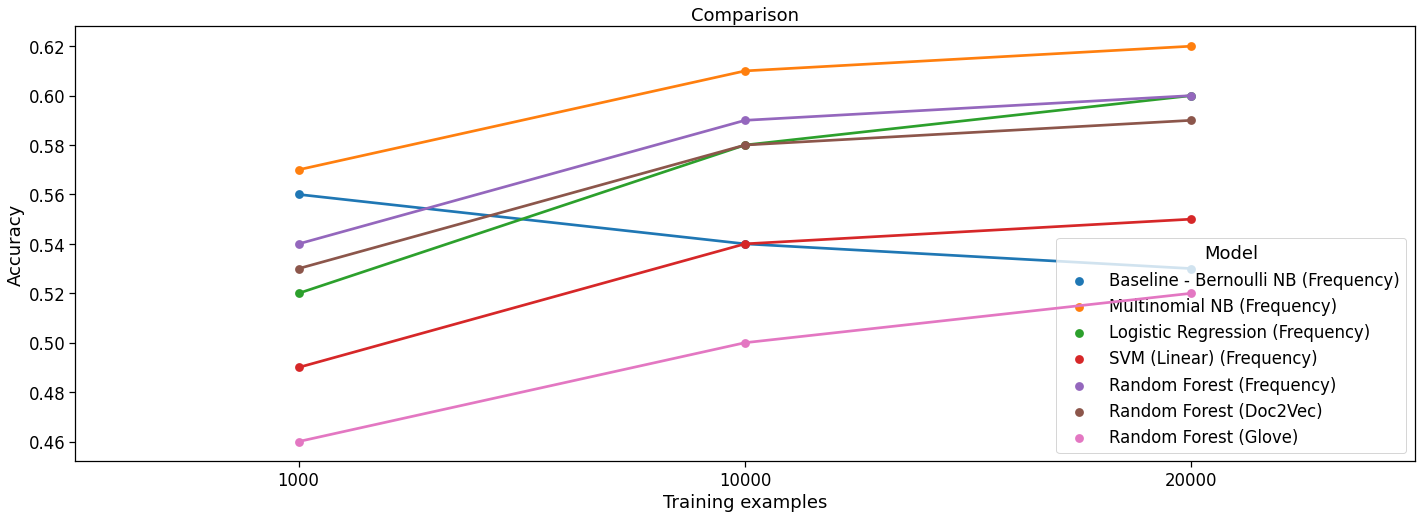

In [ ]:
plt.figure(figsize=(24, 8))
fig = sns.pointplot(x='Number of Training Samples', y='Accuracy', hue='Model', 
                    data=plotdf[plotdf.Model.map(lambda x: x in models)])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="Training examples")
fig.set(title="Comparison")
fig.set(ylabel="Accuracy")